## Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `10_SWE` 
### Using SDV to calculate total SWE

Notebook contents 
* We want to calculate total SWE from the treatment areas
* First, we report over the entire ridge using the SDV in the treatment areas before and after treatmetns 
* Then, we need to break it up by north and south side of the ridge (this will require normalizing by the total area)
* For now, we will use one snow density to determine SWE, but can make a comment in the discussion about variable snow densities on the north and south side of the ridge 

created by Cassie Lumbrazo\
last updated: June 2024\
run location: locally\
python environment: **raster**

In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

# import csv 
# import copy 
# import os.path 

import geopandas as gpd
# import rasterio
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# import rioxarray
# import rasterio

import scipy

In [2]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
# Paths for local machine
ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') 

c:\Users\Lumbr\miniconda3\envs\raster\lib\site-packages\xarray\backends\plugins.py:65: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _base: The specified module could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
ds

<xarray.Dataset>
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 2.111e+05 ... 2.097e+05
  * band                              (band) int32 1
    spatial_ref                       int32 ...
Data variables: (12/339)
    chmws_rapid                       (band, y, x) float32 ...
    dce_rapid                         (band, y, x) float32 ...
    giulia_dce_rapid                  (band, y, x) float32 ...
    giulia_dce_ncalm                  (band, y, x) float32 ...
    baf_old                           (band, y, x) float32 ...
    baf_new                           (band, y, x) float32 ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 ...

First, some constants. 

In [8]:
colorpre='darkslategray'
colorpos='royalblue'
# colorpos='mediumvioletred'

colorsouth = 'darkorange'
colornorth = 'darkblue'

## Recalculate SDV from `6_SVD` notebook 

In [5]:
# Per Justin's suggestion (thanks Justin) we should remove snow depths = 0
ds['hs_rapid_nozeros'] = ds['hs_rapid'].where(ds['hs_rapid']!=0)
ds['hs_ncalm_nozeros'] = ds['hs_ncalm'].where(ds['hs_ncalm']!=0)

# # SVD = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey
ds['sdv_rapid'] = (ds['hs_rapid'] - ds['hs_rapid'].mean(dim=['x','y'])) / ds['hs_rapid'].std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm'] - ds['hs_ncalm'].mean(dim=['x','y'])) / ds['hs_ncalm'].std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm'])

# We want to calculate SVD only using zero values 
# SVD = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey
ds['sdv_rapid_nozeros'] = (ds['hs_rapid_nozeros'] - ds['hs_rapid_nozeros'].mean(dim=['x','y'])) / ds['hs_rapid_nozeros'].std(dim=['x','y'])
ds['sdv_ncalm_nozeros'] = (ds['hs_ncalm_nozeros'] - ds['hs_ncalm_nozeros'].mean(dim=['x','y'])) / ds['hs_ncalm_nozeros'].std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm_nozeros'] = (ds['sdv_rapid_nozeros'] - ds['sdv_ncalm_nozeros'])

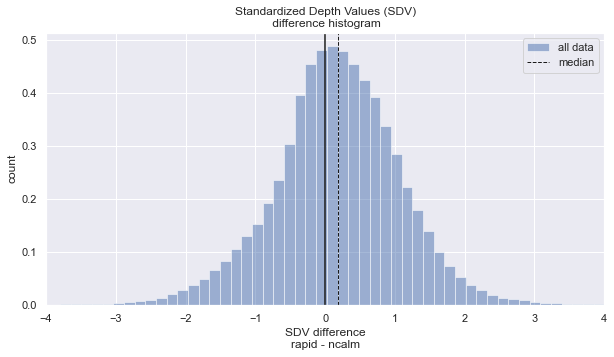

In [6]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm_nozeros'].plot.hist(bins=100, alpha=0.5, density=True, label='all data');
# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm_nozeros'].median(), color='k', linestyle='dashed', linewidth=1, label='median');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

plt.xlim(-4,4);
plt.ylabel('count')
plt.xlabel('SDV difference\nrapid - ncalm')

plt.title('Standardized Depth Values (SDV)\n difference histogram')
plt.show()

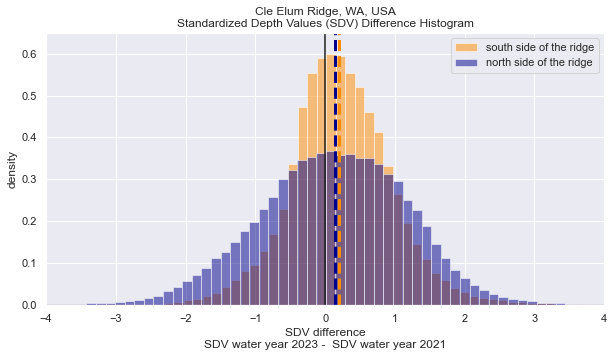

In [9]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1).plot.hist(bins=100, color=colorsouth, alpha=0.5, density=True, label='south side of the ridge');
ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1).plot.hist(bins=100, color=colornorth, alpha=0.5, density=True, label='north side of the ridge');

# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
plt.axvline(ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

plt.xlim(-4,4);
plt.ylim(0,0.65)
plt.ylabel('density')
plt.xlabel('SDV difference\nSDV water year 2023 -  SDV water year 2021')

plt.title('Cle Elum Ridge, WA, USA\nStandardized Depth Values (SDV) Difference Histogram')
plt.show()

## Now, use SDV to calculate SWE. 
Using old code from this repo: https://github.com/cassielumbrazo/RAPID_raster_analysis/blob/main/7_rapid_compare_canopy_v4.ipynb

So, we have the sdv maps for the entire ridge for both years, 
* `ds['sdv_rapid_nozeros']`
* `ds['sdv_ncalm_nozeros']`

And their difference map, 
* `ds['diff_sdv_rapid_ncalm_nozeros']`

For the  south side of the ridge, 
* `ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==   1)`,

and the north side of the ridge, 
* `ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1)`

For when we calculate SWE, 
* for snow density, we can use 310 kg/m3 (or 0.31% water) for everywhere 

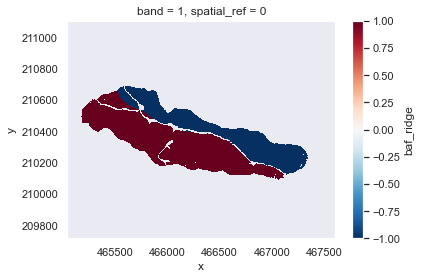

In [49]:
ds['baf_ridge'].plot()

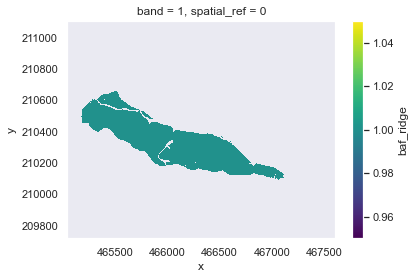

In [50]:
ds['baf_ridge'].where(ds['baf_ridge'] == 1).plot()

In [14]:
# ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1) # SDV south side of the ridge 
# ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1) # SDV north side of the ridge

# Thus, we take the (total snow depth * snow density) / the count for that area to get the normalized SWE values. 
# But, considering we have SDV values, we can also calculate the normalized SWE values using the SDV values.


In [26]:
density = 310

df_swe = pd.DataFrame({'sdv_rapid_swe':
    (ds['sdv_rapid_nozeros'].sum(dim=['x','y']).values * density), 
    'sdv_ncalm_swe':
    (ds['sdv_ncalm_nozeros'].sum(dim=['x','y']).values * density), 
    'sdv_rapid_swe_n':
    (ds['sdv_rapid_nozeros'].sum(dim=['x','y']).values * density) / (ds['sdv_rapid_nozeros'].count(dim=['x','y']).values), 
    'sdv_ncalm_swe_n':
    (ds['sdv_ncalm_nozeros'].sum(dim=['x','y']).values * density) / (ds['sdv_ncalm_nozeros'].count(dim=['x','y']).values),
    'diff_sdv_rapid_ncalm_swe':
    (ds['diff_sdv_rapid_ncalm_nozeros'].sum(dim=['x','y']).values * density), 
    'diff_sdv_rapid_ncalm_swe_n':
    (ds['diff_sdv_rapid_ncalm_nozeros'].sum(dim=['x','y']).values * density)/ (ds['diff_sdv_rapid_ncalm_nozeros'].count(dim=['x','y']).values), 
})

df_swe

,sdv_rapid_swe,sdv_ncalm_swe,sdv_rapid_swe_n,sdv_ncalm_swe_n,diff_sdv_rapid_ncalm_swe,diff_sdv_rapid_ncalm_swe_n
0,-36.056137,-7.122536,-0.000077,-0.000017,20998038.0,56.279165


In [31]:
df_swe = pd.DataFrame({
    'diff_sdv_rapid_ncalm_swe':
    (ds['diff_sdv_rapid_ncalm_nozeros'].sum(dim=['x','y']).values * density), 
    'diff_sdv_rapid_ncalm_swe_n':
    (ds['diff_sdv_rapid_ncalm_nozeros'].sum(dim=['x','y']).values * density)/ (ds['diff_sdv_rapid_ncalm_nozeros'].count(dim=['x','y']).values),
    'diff_sdv_rapid_ncalm_swe_south':
    ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1)).sum(dim=['x','y']).values * density),
    'diff_sdv_rapid_ncalm_swe_north':
    ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1)).sum(dim=['x','y']).values * density),
    'diff_sdv_rapid_ncalm_swe_south_n':
    ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1)).sum(dim=['x','y']).values * density)/ ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1)).count(dim=['x','y']).values),
    'diff_sdv_rapid_ncalm_swe_north_n':
    ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1)).sum(dim=['x','y']).values * density)/ ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1)).count(dim=['x','y']).values),  
})

df_swe.head()

,diff_sdv_rapid_ncalm_swe,diff_sdv_rapid_ncalm_swe_n,diff_sdv_rapid_ncalm_swe_south,diff_sdv_rapid_ncalm_swe_north,diff_sdv_rapid_ncalm_swe_south_n,diff_sdv_rapid_ncalm_swe_north_n
0,20998038.0,56.279165,14481427.0,6516614.5,73.847155,36.815991


In [32]:
df_swe = pd.DataFrame({
    'diff_sdv_rapid_ncalm_swe_n':
    (ds['diff_sdv_rapid_ncalm_nozeros'].sum(dim=['x','y']).values * density)/ (ds['diff_sdv_rapid_ncalm_nozeros'].count(dim=['x','y']).values),
    'diff_sdv_rapid_ncalm_swe_south_n':
    ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1)).sum(dim=['x','y']).values * density)/ ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1)).count(dim=['x','y']).values),
    'diff_sdv_rapid_ncalm_swe_north_n':
    ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1)).sum(dim=['x','y']).values * density)/ ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1)).count(dim=['x','y']).values),  
})

df_swe.head()

,diff_sdv_rapid_ncalm_swe_n,diff_sdv_rapid_ncalm_swe_south_n,diff_sdv_rapid_ncalm_swe_north_n
0,56.279165,73.847155,36.815991


You do not need the dim inside the count...

In [51]:
df_swe = pd.DataFrame({
    'diff_sdv_rapid_ncalm_swe_n':
    (ds['diff_sdv_rapid_ncalm_nozeros'].sum(dim=['x','y']).values * density)/ (ds['diff_sdv_rapid_ncalm_nozeros'].count(dim=['x','y']).values),
    'diff_sdv_rapid_ncalm_swe_south_n':
    ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1)).sum(dim=['x','y']).values * density)/ ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1)).count().values),
    'diff_sdv_rapid_ncalm_swe_north_n':
    ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1)).sum(dim=['x','y']).values * density)/ ((ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1)).count().values),  
})

df_swe.head()

,diff_sdv_rapid_ncalm_swe_n,diff_sdv_rapid_ncalm_swe_south_n,diff_sdv_rapid_ncalm_swe_north_n
0,56.279165,73.847155,36.815991


In [36]:
# rename the columns in df_swe for the plotting 
df_swe = df_swe.rename(columns={
    'diff_sdv_rapid_ncalm_swe_n':'all data',
    'diff_sdv_rapid_ncalm_swe_south_n':'south side of the ridge',
    'diff_sdv_rapid_ncalm_swe_north_n':'north side of the ridge'
})

In [45]:
sns.set_theme()

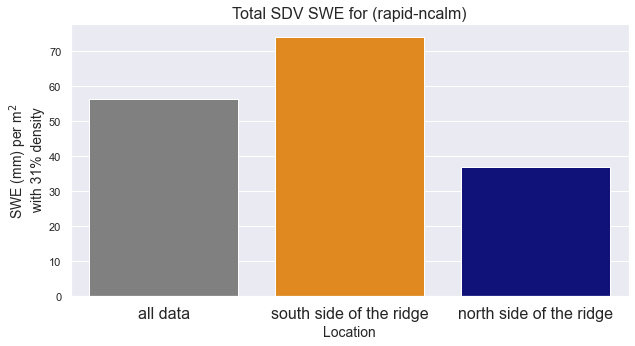

In [48]:
fig = plt.figure(figsize=(10,5))
sns.barplot(data=df_swe, ci='sd', palette=['grey', colorsouth, colornorth])
plt.title('Total SDV SWE for (rapid-ncalm)', fontsize=16)
plt.xlabel('Location', fontsize=14)
plt.ylabel('SWE (mm) per m$^2$\n with 31% density', fontsize=14)
plt.xticks(fontsize=16)
plt.show()